In [1]:
import os, glob, re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

FEATURE_DIR = "NSR_SCD_FEATS_EX"   # change if needed

In [2]:
def parse_filename(path):
    name = os.path.basename(path)
    is_scd = name.startswith("SCD")
    parts  = name.split('_')
    subj   = parts[1]
    ordinal = parts[2]                # First…Sixth
    order = ["First","Second","Third","Fourth","Fifth","Sixth"]
    idx = order.index(ordinal)
    # SCD order reversed: Sixth→0 … First→5
    idx = 5 - idx if is_scd else idx
    return int(is_scd), subj, idx

In [3]:
FEATURE_DIR = "NSR_SCD_FEATS_EX" 

def load_subject_dict(feature_dir):
    subj_map = {}
    for path in glob.glob(os.path.join(feature_dir, "*.csv")):
        label, subj, seg_idx = parse_filename(path)
        features = pd.read_csv(path).values.squeeze()   # eight‑element row

        print(label, features)
        if subj not in subj_map:
            subj_map[subj] = {"label": label, "segments": [None]*6}
        subj_map[subj]["segments"][seg_idx] = features
    # check completeness
    # for s, info in subj_map.items():
    #     if None in info["segments"]:
    #         raise ValueError(f"Subject {s} missing segment(s)")
    return subj_map

subject_dict = load_subject_dict(FEATURE_DIR)
print("Loaded", len(subject_dict), "subjects")

0 [0.7628077  0.32957674 0.03820513 0.22607643 0.02963741 0.149
 0.5859375  2.3671875 ]
0 [0.72310915 0.37386428 0.04552058 0.27241548 0.0376728  0.188
 0.5078125  2.5       ]
0 [0.76578608 0.34806866 0.04005168 0.24525634 0.03202674 0.155
 0.6171875  2.7578125 ]
0 [0.61649485 0.33394713 0.05475207 0.24804254 0.04023432 0.265
 0.3671875  2.25      ]
0 [0.78543307 0.36229085 0.04894737 0.26408974 0.03362346 0.186
 0.5859375  2.25      ]
0 [0.78034777 0.31394761 0.05342105 0.23146456 0.02966172 0.203
 0.5        2.078125  ]
0 [0.69551235 0.51237611 0.09393939 0.3568464  0.05130698 0.403
 0.25       2.5625    ]
0 [0.69657494 0.50386794 0.0943662  0.36251678 0.05204275 0.402
 0.125      2.0390625 ]
0 [0.72401536 0.47834206 0.08731707 0.36726377 0.05072596 0.358
 0.125      2.859375  ]
0 [0.62947368 0.45919998 0.09092827 0.31560428 0.0501378  0.431
 0.1328125  1.8046875 ]
0 [0.66488211 0.50291776 0.09731544 0.32376281 0.04869477 0.435
 0.2578125  2.3125    ]
0 [0.67767654 0.58217566 0.08630

In [4]:
X_tr, y_tr, X_te, y_te = [], [], [], []

for subj, info in subject_dict.items():
    lbl  = info["label"]
    segs = info["segments"]
    X_tr.append(segs[0])              # first 5‑min
    y_tr.append(lbl)
    X_te.extend(segs[1:])             # remaining 5
    y_te.extend([lbl]*5)

In [7]:
X_tr = np.vstack(X_tr)
#X_te = np.vstack(X_te)
y_tr = np.array(y_tr)
#y_te = np.array(y_te)

In [8]:
scaler = StandardScaler().fit(X_tr)

In [9]:
X_tr = scaler.transform(X_tr)
#X_te = scaler.transform(X_te)

In [ ]:
# # WaveNet HRV Notebook ❱ Full Pipeline + Plots  (***updated hybrid CNN***)

# N_FILT, K, DIL_BASE, DROP, DENSE = 64, 2, [1,2,4,8,16,32,64], 0.5, 512

# def inception_branch(x, f, k):
#     return layers.Conv1D(f, k, padding="same", activation="relu")(x)

# def se_block(x, r=7):
#     ch = x.shape[-1]
#     s  = layers.GlobalAveragePooling1D()(x)
#     s  = layers.Dense(ch//r, activation="relu")(s)
#     s  = layers.Dense(ch,      activation="sigmoid")(s)
#     s  = layers.Reshape((1, ch))(s)
#     return layers.Multiply()([x, s])

# def build_wavenet(depth, lr):
#     """Hybrid Inception‑Dense‑SE 1‑D CNN (depth = # hybrid blocks)."""
#     inp = Input(shape=(8,))
#     x   = layers.Reshape((8,1))(inp)
#     # point‑wise embedding
#     x   = layers.Conv1D(128, 1, activation="relu")(x)
#     x   = layers.BatchNormalization()(x)

#     for b in range(depth):
#         # ── Inception‑style multi‑kernel fan‑out
#         b1 = inception_branch(x, 64, 1)
#         b2 = inception_branch(x, 64, 3)
#         b3 = inception_branch(x, 64, 5)
#         merge = layers.Concatenate()([b1, b2, b3])
#         merge = layers.BatchNormalization()(merge)

#         # ── SE attention
#         merge = se_block(merge)

#         # ── Dense concatenation (DenseNet‑style growth)
#         x = layers.Concatenate()([x, merge])

#     # global context pool + classifier
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dropout(DROP)(x)
#     x = layers.Dense(DENSE, activation="relu")(x)
#     x = layers.Dropout(DROP)(x)
#     out = layers.Dense(1, activation="sigmoid")(x)

#     model = Model(inp, out, name="Hybrid_InceptionDense_SE")
#     model.compile(tf.keras.optimizers.Adam(lr),
#                   loss="binary_crossentropy", metrics=["accuracy"])
#     return model

In [10]:
N_FILT, K, DIL_BASE, DROP, DENSE = 64, 2, [1,2,4,8,16,32,64], 0.5, 512

# def build_wavenet(depth, lr):
#     dil = DIL_BASE[:depth]
#     inp = Input(shape=(9,))
#     x   = layers.Reshape((9,1))(inp); skips=[]
#     for d in dil:
#         t=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='tanh')(x)
#         s=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='sigmoid')(x)
#         g=layers.Multiply()([t,s])
#         skips.append(layers.TimeDistributed(layers.Dense(N_FILT,activation='relu'))(g))
#         x=layers.Add()([x,g])
#     x=layers.Add()(skips); x=layers.Activation('relu')(x); x=layers.Flatten()(x)
#     x=layers.Dropout(DROP)(x); x=layers.Dense(DENSE,activation='relu')(x); x=layers.Dropout(DROP)(x)
#     out=layers.Dense(1,activation='sigmoid')(x)
#     m=Model(inp,out); m.compile(tf.keras.optimizers.Adam(lr),'binary_crossentropy',['accuracy'])
#     return m

def build_wavenet(depth, lr):
    dilations = DIL_BASE[:depth]
    inp = Input(shape=(8,))
    x   = layers.Reshape((8,1))(inp)
    skips = []
    for d in dilations:
        t = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="tanh")(x)
        s = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="sigmoid")(x)
        g = layers.Multiply()([t, s])
        skips.append(layers.TimeDistributed(layers.Dense(N_FILT,
                               activation="relu"))(g))
        x = layers.Add()([x, g])          # residual
    x = layers.Add()(skips)
    x = layers.Activation("relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(DROP)(x)
    x = layers.Dense(DENSE, activation="relu")(x)
    x = layers.Dropout(DROP)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [11]:
configs = [(3,0.1,32),(5,0.01,64),(7,0.001,128),(9,0.0001,256)]
histories, models = {}, {}
for d,lr,bs in configs:
    key=f"d{d}_lr{lr}_bs{bs}"
    print("Training",key)
    m=build_wavenet(d,lr)
    h=m.fit(X_tr,y_tr,epochs=150,batch_size=bs,verbose=0)   # no validation
    histories[key]=h
    models[key]=m
    print("  final loss=",h.history['loss'][-1]," acc=",h.history['accuracy'][-1])

Training d3_lr0.1_bs32
  final loss= 0.0  acc= 1.0
Training d5_lr0.01_bs64
  final loss= 4.505936601617577e-08  acc= 1.0
Training d7_lr0.001_bs128
  final loss= 0.00022856953728478402  acc= 1.0
Training d9_lr0.0001_bs256
  final loss= 0.0577055998146534  acc= 1.0


In [12]:
best_key = min(histories,
               key=lambda k:(histories[k].history['loss'][-1],
                             -histories[k].history['accuracy'][-1]))
best_model = models[best_key]
print("BEST model →", best_key)

BEST model → d3_lr0.1_bs32


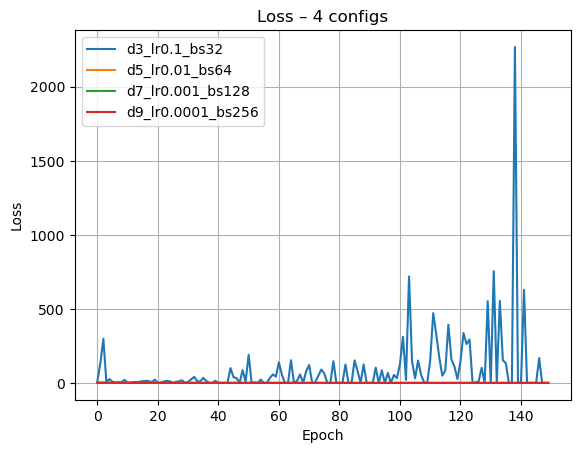

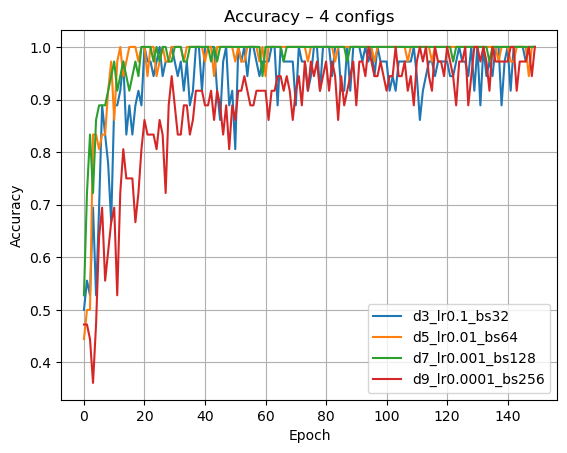

In [13]:
import matplotlib.pyplot as plt
# 1+2 plots
plt.figure(); 
plt.title("Loss – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['loss'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); 
plt.grid(); 
plt.show()

plt.figure(); 
plt.title("Accuracy – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['accuracy'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.grid(); 
plt.show()

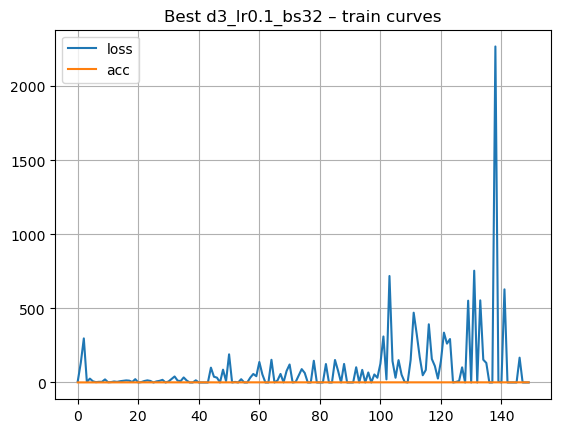

In [14]:
# 3 detailed curve for best
h=histories[best_key]
plt.figure(); 
plt.plot(h.history['loss'],label='loss'); 
plt.plot(h.history['accuracy'],label='acc')
plt.title(f"Best {best_key} – train curves"); 
plt.legend(); 
plt.grid(); 
plt.show()

In [15]:
slice_X, slice_y = [[] for _ in range(5)], [[] for _ in range(5)]

for subj, info in subject_dict.items():
    lbl  = info["label"]
    for i in range(5):
        slice_X[i].append(info["segments"][i+1])
        slice_y[i].append(lbl)

In [16]:
slice_X = [np.vstack(s) for s in slice_X]
slice_y = [np.array(s) for s in slice_y]

In [19]:
slice_X

[array([[6.16494845e-01, 3.33947134e-01, 5.47520661e-02, 2.48042538e-01,
         4.02343247e-02, 2.65000000e-01, 3.67187500e-01, 2.25000000e+00],
        [6.29473684e-01, 4.59199976e-01, 9.09282700e-02, 3.15604275e-01,
         5.01378029e-02, 4.31000000e-01, 1.32812500e-01, 1.80468750e+00],
        [7.83136483e-01, 4.10693179e-01, 5.81578947e-02, 2.93853594e-01,
         3.75226541e-02, 2.21000000e-01, 4.37500000e-01, 2.50000000e+00],
        [6.88796083e-01, 3.36169248e-01, 7.22863741e-02, 2.58057069e-01,
         3.74649444e-02, 3.13000000e-01, 1.40625000e-01, 2.56250000e+00],
        [3.85446831e-01, 2.97126320e-01, 9.44587629e-02, 1.97375871e-01,
         5.12070291e-02, 7.33000000e-01, 1.79687500e-01, 2.62500000e+00],
        [4.30137140e-01, 2.39878388e-01, 8.38616715e-02, 2.05283937e-01,
         4.77252294e-02, 5.82000000e-01, 1.40625000e-01, 1.43750000e+00],
        [4.78600000e-01, 3.79655936e-01, 9.15064103e-02, 2.36513367e-01,
         4.94177533e-02, 5.71000000e-01, 1.79

In [20]:
slice_X = [scaler.transform(s) for s in slice_X]

In [21]:
slice_X

[array([[-2.82991360e-01, -3.66558718e-01, -1.93136253e+00,
         -3.33813097e-01, -4.08140637e-01, -6.77872827e-01,
          1.05706409e+00, -2.97919519e-01],
        [-2.56162108e-01, -2.94380515e-01,  5.12407520e-01,
         -2.88825453e-01, -2.84361410e-01,  2.99441531e-01,
         -1.06887486e+00, -3.26747722e-01],
        [ 6.14824835e-02, -3.22333042e-01, -1.70129246e+00,
         -3.03308679e-01, -4.42032617e-01, -9.36920006e-01,
          1.69484577e+00, -2.81735266e-01],
        [-1.33533604e-01, -3.65278203e-01, -7.46887321e-01,
         -3.27144675e-01, -4.42753906e-01, -3.95275904e-01,
         -9.98010226e-01, -2.77689202e-01],
        [-7.60603072e-01, -3.87777081e-01,  7.50898898e-01,
         -3.67550743e-01, -2.70997620e-01,  2.07744717e+00,
         -6.43687069e-01, -2.73643139e-01],
        [-6.68221342e-01, -4.20766774e-01,  3.50456055e-02,
         -3.62284963e-01, -3.14515107e-01,  1.18844435e+00,
         -9.98010226e-01, -3.50518344e-01],
        [-5.6804

In [22]:

# 4 confusion per slice
global_cm=np.zeros((2,2),int)
for i,(X_s,y_s) in enumerate(zip(slice_X,slice_y),start=2):
    y_pr=(best_model.predict(X_s).ravel()>=0.5).astype(int)
    cm=confusion_matrix(y_s,y_pr); global_cm+=cm
    tn,fp,fn,tp=cm.ravel()
    acc=(tp+tn)/cm.sum(); sens=tp/(tp+fn); spec=tn/(tn+fp); prec=tp/(tp+fp)
    print(f"Slice {i}‑th 5‑min  CM={cm.tolist()}  Acc={acc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  Prec={prec:.3f}")
    print(f"\\nGLOBAL CM =\\n", global_cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
Slice 2‑th 5‑min  CM=[[18, 0], [0, 18]]  Acc=1.000  Sens=1.000  Spec=1.000  Prec=1.000
\nGLOBAL CM =\n [[18  0]
 [ 0 18]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Slice 3‑th 5‑min  CM=[[18, 0], [2, 16]]  Acc=0.944  Sens=0.889  Spec=1.000  Prec=1.000
\nGLOBAL CM =\n [[36  0]
 [ 2 34]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Slice 4‑th 5‑min  CM=[[17, 1], [1, 17]]  Acc=0.944  Sens=0.944  Spec=0.944  Prec=0.944
\nGLOBAL CM =\n [[53  1]
 [ 3 51]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Slice 5‑th 5‑min  CM=[[15, 3], [1, 17]]  Acc=0.889  Sens=0.944  Spec=0.833  Prec=0.850
\nGLOBAL CM =\n [[68  4]
 [ 4 68]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Slice 6‑th 5‑min  CM=[[15, 3], [0, 18]]  Acc=0.917  Sens=1.000  Spec=0.833  Prec=0.857
\nGLOBAL CM =\n [[83  7]
 [ 4 86]]
